In [2]:
import sys

if 'mitsuba' not in sys.modules:
    import mitsuba as mi

    for variant in (['cuda_ad_rgb', 'llvm_ad_rgb', 'scalar_rgb']):
        try:
            mi.set_variant(variant)
            print(f'Using {variant.split('_')[0].upper()} backend')
            break
        except ImportError:
            pass

from mitsuba import ScalarTransform4f as ST
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np

Using CUDA backend


## Mesh reading, image taking

In [3]:
print("Available objects:")
print("\n".join([p.stem for p in Path(f'../data/raw_objects/').iterdir() if p.is_dir()]))

Available objects:
76_POLY_BANANAS
BOBER
CHINDILA
Ecoforms_Plant_Container_S14Turquoise
LUCKY_CAT
LUXURY_FISH
MAXWELL
NICE_98_POLY_CAR
SAPPHIRE_R7_260X_OC
Shurtape_Tape_Purple_CP28
THE_MUSK
Weisshai_Great_White_Shark
WISE_HORSE


In [4]:
obj = 'Weisshai_Great_White_Shark'
obj_path = Path(f'../data/raw_objects/{obj}/').absolute()

def load_and_normalize_mesh(obj_path: Path) -> mi.Mesh:
    mesh: mi.Mesh = mi.load_dict({
        'type': 'obj',
        'filename': (obj_path / 'meshes/model.obj').as_posix(),
    })

    bbox = mesh.bbox()  # Used for re-centering and scaling to -1:1 bounding box

    mesh: mi.Mesh = mi.load_dict({
        'type': 'obj',
        'filename': (obj_path / 'meshes/model.obj').as_posix(),
        'to_world': ST().scale(1 / max(abs(bbox.max - bbox.min) / 2)).translate(-(bbox.max + bbox.min) / 2),
        'bsdf': {
            'type': 'diffuse',
            'reflectance': {
                'type': 'bitmap',
                'filename': (obj_path / 'materials/textures/texture.png').as_posix(),
                'wrap_mode': 'clamp',
                'filter_type': 'bilinear',
            }
        },
    })

    return mesh


mesh = load_and_normalize_mesh(obj_path)
mesh.bbox()

BoundingBox3f[
  min = [-0.860059, -1, -0.447512],
  max = [0.860059, 1, 0.447512]
]

In [ ]:
sensor = mi.load_dict({
    'type': 'perspective',
    'fov': 40,
    'fov_axis': 'x',
    'to_world': ST().look_at(
        origin=[
            4 * np.sin(np.pi / 4) * np.cos(np.pi / 4),
            4 * np.sin(np.pi / 4) * np.sin(np.pi / 4),
            4 * np.cos(np.pi / 4),
        ],
        target=[0, 0, 0],
        up=[0, 0, 1],
    )
})

def sensor_c2w(sensor: mi.Sensor):
    transf = np.array(sensor.world_transform().matrix, dtype=np.float32)
    if len(transf.shape) > 2:
        transf = transf[:, :, 0]
    # transforming z-forward, x-left to z-backward, x-right
    transf[:3, 2] *= -1
    transf[:3, 0] *= -1
    return transf

print(sensor_c2w(sensor))

[[-0.70710677 -0.49999997  0.5         2.        ]
 [ 0.70710677 -0.49999997  0.5         2.        ]
 [-0.          0.70710677  0.70710677  2.828427  ]
 [ 0.          0.          0.          1.        ]]


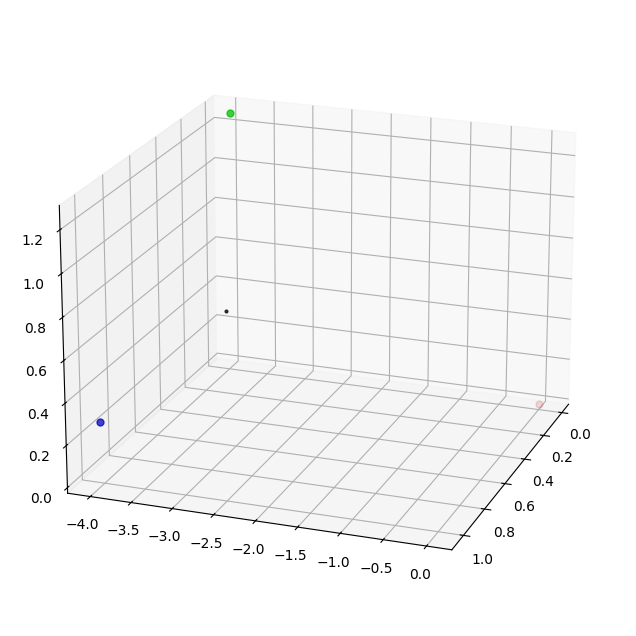

In [24]:
scene_dict: dict = {
    'type': 'scene',
    'integrator': {
        'type': 'direct'
    },
    'obj': mesh,
    'light': {
        'type': 'constant',
        'radiance': {
            'type': 'rgb',
            'value': 1.0,
        }
    },
    'x': {
        'type': 'sphere',
        'radius': 0.1,
        'to_world': ST().translate([1,0,0]),
        'bsdf': {
            'type': 'diffuse',
            'reflectance': {
                'type': 'rgb',
                'value': [1, 0, 0]
            }
        }
    },
    'y': {
        'type': 'sphere',
        'radius': 0.1,
        'to_world': ST().translate([0,1,0]),
        'bsdf': {
            'type': 'diffuse',
            'reflectance': {
                'type': 'rgb',
                'value': [0, 1, 0]
            }
        }
    },
    'z': {
        'type': 'sphere',
        'radius': 0.1,
        'to_world': ST().translate([0,0,1]),
        'bsdf': {
            'type': 'diffuse',
            'reflectance': {
                'type': 'rgb',
                'value': [0, 0, 1]
            }
        }
    },
}

scene: mi.Scene = mi.load_dict(scene_dict)


def create_batch_sensor(n: int, radius: float, size: int = 800, fov_x: float = 40, deterministic=False) -> mi.Sensor:
    focal = (size / 2) / np.tan(np.deg2rad(fov_x) / 2)

    i = np.arange(0, n, dtype=float) + 0.5
    if not deterministic:
        i = i + np.random.uniform(-0.5, 0.5, size = n) / n
        
    phis = np.pi * i * (1 + np.sqrt(5))
    thetas = np.arccos(1 - 2 * i / n)

    sensors: list[mi.Sensor] = [mi.load_dict({
        'type': 'perspective',
        'fov': fov_x,
        'fov_axis': 'x',
        'to_world': ST().look_at(
            origin=[
                radius * np.sin(theta) * np.cos(phi),
                radius * np.sin(theta) * np.sin(phi),
                radius * np.cos(theta),
            ],
            target=[0, 0, 0],
            up=[0, 0, 1],
        )
    }) for phi, theta in zip(phis, thetas)]

    extrinsics: np.ndarray = np.stack([sensor_c2w(s) for s in sensors], axis=0)

    batch_sensor = {
        'type': 'batch',
        'sampler': {
            'type': 'ldsampler',
            'sample_count': 64,
        },
        'film': {
            'type': 'hdrfilm',
            'width': size * len(sensors),
            'height': size,
            'pixel_format': 'rgba',
            'filter': {
                'type': 'tent'
            }
        },
    }
    batch_sensor.update({f's{i}': s for i, s in enumerate(sensors)})

    return mi.load_dict(batch_sensor), extrinsics, focal.astype(np.float32)

img_size = 200
sensor_count = 1
radius = 4

sensor, extrinsics, focal = create_batch_sensor(sensor_count, radius, size=img_size, deterministic=False)

fig, ax = plt.subplots(1, 1, figsize=(8,8), subplot_kw={"projection": "3d"})
points = extrinsics[:, :3, -1]
vectors = np.zeros([extrinsics.shape[0], 3])
vectors1 = np.zeros([extrinsics.shape[0], 3])
vectors2 = np.zeros([extrinsics.shape[0], 3])
for i, ex in enumerate(extrinsics):
    vectors[i] = np.array([0,0,-4]) @ ex[:3,:3].T + points[i]
    vectors1[i] = np.array([0,1,0]) @ ex[:3,:3].T + points[i]
    vectors2[i] = np.array([1,0,0]) @ ex[:3,:3].T + points[i]

ax.plot(points[:, 0], points[:, 1], points[:, 2], linewidth=0, markersize=2, marker='o', color="#000B")
# Good if reds overlap
ax.plot(vectors[:, 0], vectors[:, 1], vectors[:, 2], linewidth=0, markersize=5, marker='o', color="#B002")
ax.plot(vectors1[:, 0], vectors1[:, 1], vectors1[:, 2], linewidth=0, markersize=5, marker='o', color="#0B0B")
ax.plot(vectors2[:, 0], vectors2[:, 1], vectors2[:, 2], linewidth=0, markersize=5, marker='o', color="#00BB")
ax.view_init(20, 20, 0)

Alpha sums:   268_195 Total pixel count: 2_560_000


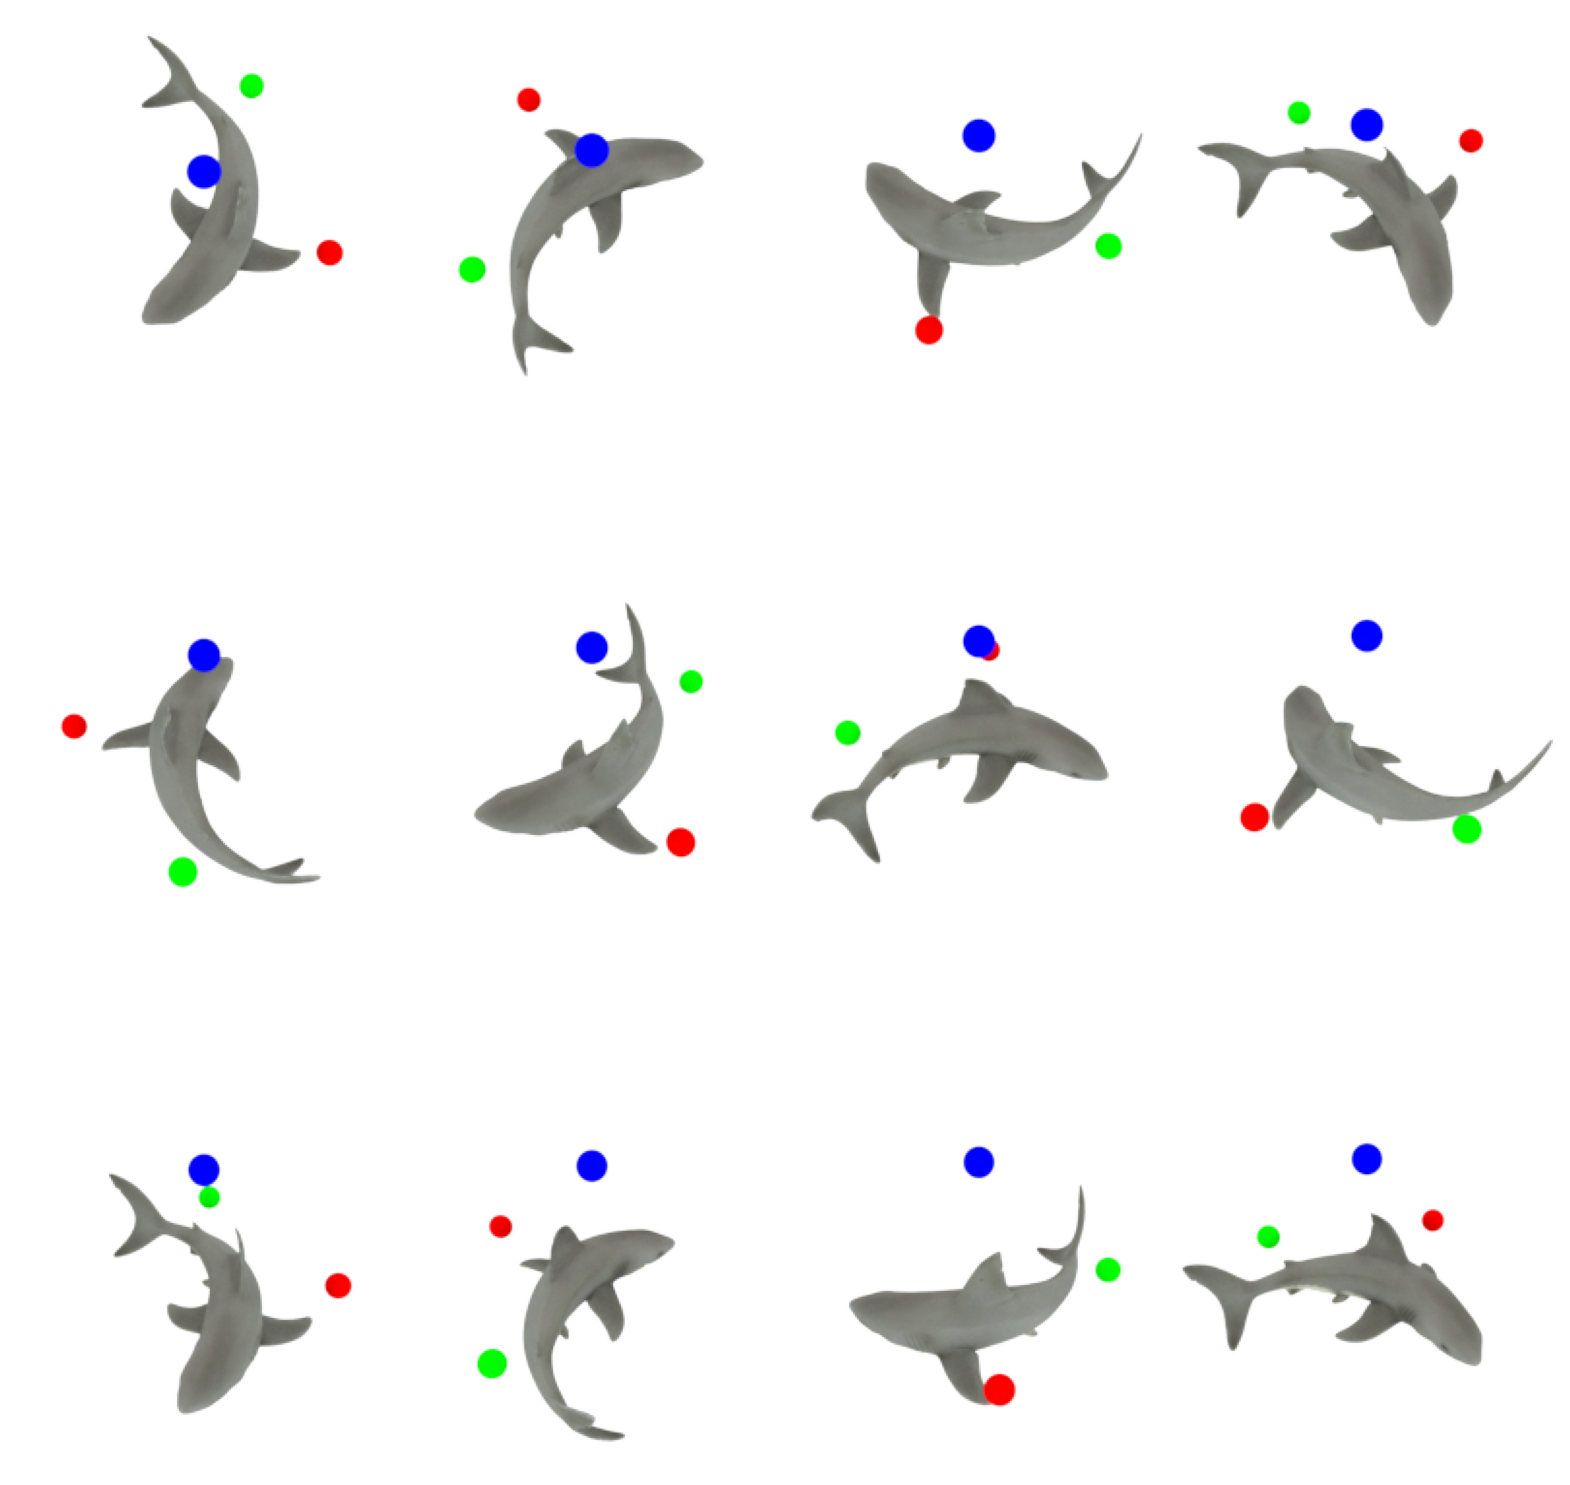

In [7]:
render = np.asarray(mi.render(scene, sensor=sensor), dtype=np.float32).clip(0,1)
# This is complicated because srgb conversion is done here too (saving to disk would do this too)
# If saving to disk is the goal, this shouldn't be done as the conversion would happen again
# This is bypassed by converting here, then saving as .npz which doesn't do a conversion
images = np.asarray(mi.Bitmap(render).convert(srgb_gamma=True, component_format=mi.Struct.Type.Float32))

images = images.reshape(img_size, -1, img_size, 4).transpose(1, 0, 2, 3)
print(f"Alpha sums: {round(images[..., 3].sum()):9_d} Total pixel count: {images.shape[0]*images.shape[1]*images.shape[2]:9_d}")
fig = plt.figure(figsize=(20, 28))
fig.subplots_adjust(wspace=0, hspace=0)
for i in range(12):
    ax = fig.add_subplot(4, 4, i + 1).imshow(images[i])
    plt.axis("off")

In [8]:
np.savez_compressed(obj, images=images, c2ws=extrinsics, focal=focal)

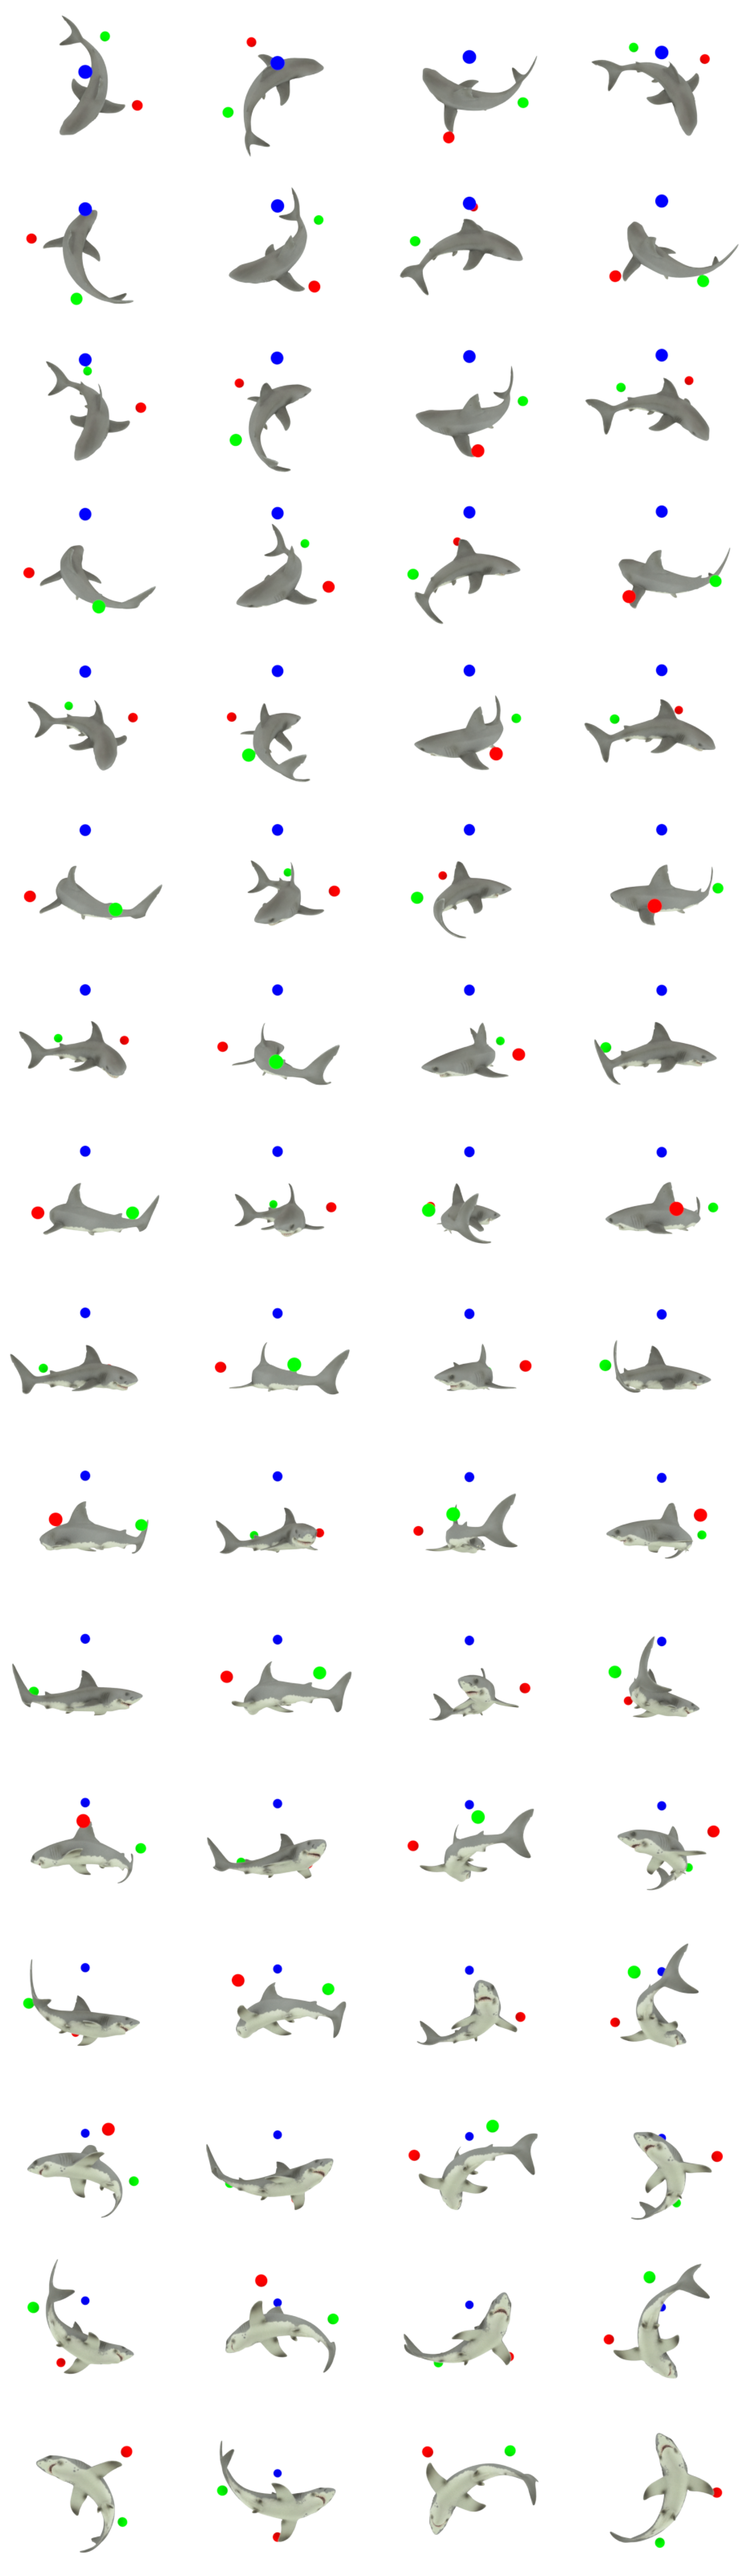

In [9]:
fig = plt.figure(figsize=(5 * 4, 5 * images.shape[0] // 4 + 4))
fig.subplots_adjust(wspace=0, hspace=0)
for i in range(images.shape[0]):
    ax = fig.add_subplot(images.shape[0] // 4 + 4, 4, i + 1).imshow(images[i])
    plt.axis("off")